# Bayesian data analysis - beta blocker cross-validation demo

Demonstration of simple model we trust. In this case, cross-validation is not needed and we can get better accuracy using the explicit model.

Import libraries

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.3


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Comparison of two groups with Binomial

An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients (this example is used also in BDA3 chapter 3). A group of patients were randomly assigned to treatment and control groups:

- out of 674 patients receiving the control, 39 died
- out of 680 receiving the treatment, 22 died


In [2]:
d_bin2 = pd.DataFrame(dict(N = np.asarray([674, 680]),
                           y = np.asarray([39,22]),
                           grp2 = np.asarray([0,1])))

d_bin2

,N,grp2,y
0,674,0,39
1,680,1,22


To match the priors used in rstanarm, we specify the prior below:

In [3]:
family = pm.glm.families.Binomial(priors = {'n': np.asarray(d_bin2['N'])})
with pm.Model() as glm1:
    pm.glm.GLM.from_formula(
        'y ~ grp2', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    grp2=pm.Normal.dist(mu=0, sd=2.5)),
        family=family,
              )
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grp2, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 503.33it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '20547' (I am process '20548')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20547' (I am process '20549')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20548' (I am process '20549')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
The acceptance probability does not match the

In [4]:
# import patsy
# y, x = patsy.dmatrices('y ~ grp2', d_bin2)
# labels = x.design_info.column_names
# y = np.asarray(y.flatten())
# x = np.asarray(x)

# with pm.Model() as glm1:
#     pm.glm.GLM(x, y, labels=labels, intercept=False,
#                priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
#                            grp2=pm.Normal.dist(mu=0, sd=2.5)),
#                family=famil,
#               )
#     trace = pm.sample(1000, tune=1000, cores=4)

In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-2.804996,0.167592,0.004040,-3.141054,-2.493176,1802.339486,1.001930
grp2,-0.611332,0.274716,0.005954,-1.127646,-0.064818,1924.746950,0.999708


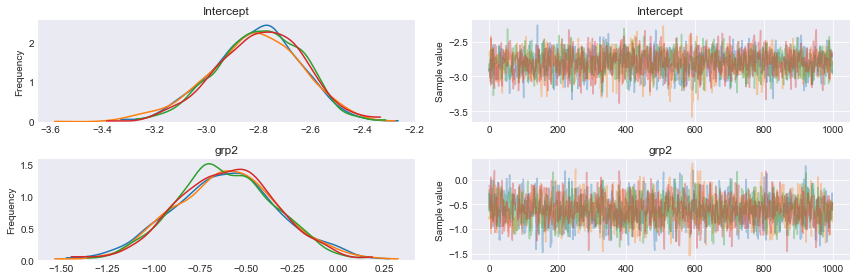

In [6]:
pm.traceplot(trace);

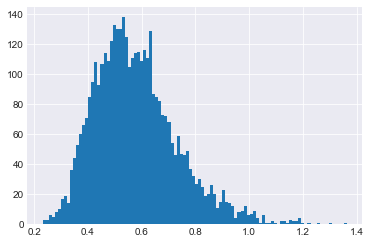

In [7]:
from scipy.stats import logistic
theta1 = logistic.pdf(trace['Intercept'])
theta2 = logistic.pdf(trace['Intercept'] + trace['grp2'])
oddsratio = (theta2/(1-theta2))/(theta1/(1-theta1))
plt.hist(oddsratio, 100);

In [8]:
print('The probability that odds-ratio is less than 1: %.2f'%np.mean(oddsratio<1))

The probability that odds-ratio is less than 1: 0.99


Demonstrate one of the weakneses of cross-validation (same holds for WAIC etc):

In [9]:
d_bin2 =pd.DataFrame(dict(N = 674+680,
                          y = np.hstack((np.ones(39), np.zeros(674-39), 
                                         np.ones(22), np.zeros(680-22))),
                          grp2 = np.hstack((np.zeros(674), np.ones(680)))))

In [10]:
family = pm.glm.families.Binomial()
with pm.Model() as glm1:
    pm.glm.GLM.from_formula(
        'y ~ grp2', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    grp2=pm.Normal.dist(mu=0, sd=2.5)),
        family=family,
              )
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grp2, Intercept]
100%|██████████| 2000/2000 [00:09<00:00, 217.21it/s]
The acceptance probability does not match the target. It is 0.8816054762305232, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-2.800141,0.162858,0.003875,-3.118541,-2.48997,1662.670883,1.000429
grp2,-0.608462,0.271377,0.006418,-1.134419,-0.07404,1449.657227,1.001173


In [12]:
with pm.Model() as glm0:
    pm.glm.GLM.from_formula(
        'y ~ 1', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10)),
        family=family,
              )
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]
100%|██████████| 2000/2000 [00:06<00:00, 332.06it/s]


In [13]:
pm.loo(trace, model=glm1)

LOO_r(LOO=496.1108294911973, LOO_se=46.60937959255268, p_LOO=1.9445511365067034, shape_warn=0)

In [14]:
pm.loo(trace0, model=glm0)

LOO_r(LOO=499.5208554291372, LOO_se=46.824677633117126, p_LOO=1.0587595741349105, shape_warn=0)

In [15]:
pm.compare(traces=[trace, trace0],
           models=[glm1, glm0],
           ic='LOO'
        )

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
0,496.11,1.94,0,0.83,46.61,0,0
1,499.52,1.06,3.41,0.17,46.82,4.56,0


The loo function in PyMC3 doesnt provides all the information necessary, use new functions instead:

In [16]:
import loo
df_loo, pointwise = loo.loo(trace, model=glm1)
df_loo.round(1)

Computed from 4000 by 1354 log-likelihood matrix


,Estimate,SE
elpd_loo,-248.1,23.3
p_loo,1.9,0.2
looic,496.1,46.6


In [17]:
pointwise

{'elpd_loo': array([-2.87181035, -2.87181035, -2.87181035, ..., -0.03327733,
        -0.03327733, -0.03327733]),
 'ks': array([-0.07187783, -0.07187783, -0.07187783, ..., -0.10876611,
        -0.10876611, -0.10876611]),
 'looic': array([5.7436207 , 5.7436207 , 5.7436207 , ..., 0.06655466, 0.06655466,
        0.06655466]),
 'p_loo': array([2.35857123e-02, 2.35857123e-02, 2.35857123e-02, ...,
        4.76132142e-05, 4.76132142e-05, 4.76132142e-05])}

In [18]:
df_k = loo.ks_summary(pointwise['ks'])

All Pareto k estimates are good (k < 0.5)


In [19]:
df_loo0, pointwise0 = loo.loo(trace0, model=glm0)
df_loo0.round(1)

Computed from 4000 by 1354 log-likelihood matrix


,Estimate,SE
elpd_loo,-249.8,23.4
p_loo,1.1,0.1
looic,499.5,46.8


In [20]:
df_k0 = loo.ks_summary(pointwise0['ks'])

All Pareto k estimates are good (k < 0.5)


All k<0.5 and we can trust PSIS-LOO result.

Now make pairwise comparison.

In [21]:
comp = loo.compare([pointwise, pointwise0])
comp.round(1)

,elpd_diff,se
m1-m0,-1.7,2.3


> `elpd_diff` is small compared to se, and thus cross-validation is uncertain whether would be significant improvement in predictive performance! To put this in persepective, we have N1=674 and N2=680, and 5.8% and 3.2% deaths, and this is now too weak information for cross-validation.

Simulation study similar to `binom_odds_comparison.R`